In [2]:
!python --version

Python 3.6.6


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Désactive le GPU et utilise le CPU uniquement


In [4]:
import tensorflow as tf
import skimage
import keras

print("TensorFlow version:", tf.__version__)
print("scikit-image version:", skimage.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 1.15.0
scikit-image version: 0.17.2
Keras version: 2.1.6


Using TensorFlow backend.


In [5]:
import tensorflow as tf

# Test simple sur CPU
a = tf.constant([1, 2, 3])
b = tf.constant([4, 5, 6])
c = tf.add(a, b)

# Créez une session pour évaluer le résultat
with tf.Session() as sess:
    result = sess.run(c)
    print(result)  # Devrait afficher [5, 7, 9]


[5 7 9]


In [6]:


# List available GPUs
gpus = tf.GPUOptions()

# Check for available devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU') if hasattr(tf, 'config') else tf.test.gpu_device_name()

# Print the number of available GPUs
if gpu_devices:
    print("Num GPUs Available: ", len(gpu_devices))
else:
    print("No GPUs available")


No GPUs available


In [7]:
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

In [8]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [9]:
from mrcnn.config import Config

class DroneConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 0  # Pas de GPU
    IMAGES_PER_GPU = 1  # Une image à la fois sur le CPU
    NUM_CLASSES = 1 + 2  # Background + classes "drone"
    STEPS_PER_EPOCH = 10
    DETECTION_MIN_CONFIDENCE = 0.9


In [10]:
import os
import json
import numpy as np
from skimage.io import imread
from mrcnn.utils import Dataset
from sklearn.model_selection import train_test_split
from skimage.draw import polygon as draw_polygon  # Correctly import the draw_polygon function

class DroneDataset(Dataset):
    def load_drone(self, dataset_dir, subset):
        """
        Load a subset of the drone dataset where each image has its own annotation JSON file.
        Args:
            dataset_dir: Root directory of the dataset.
            subset: Subset to load (train/val/test).
        """
        # Add a single class for "drone"
        self.add_class("drone", 1, "drone")
        
        # Define the directory for this subset (train/val/test)
        subset_dir = os.path.join(dataset_dir, subset)
        
        # Define and check image and annotation directories
        image_dir = os.path.join(subset_dir, "images")
        annotation_dir = os.path.join(subset_dir, "annotations")
        
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(annotation_dir):
            raise FileNotFoundError(f"Annotation directory not found: {annotation_dir}")
        
        # List all image files in the subset directory
        image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png"))]
        
        # Initialize an empty list to hold all annotations
        annotations = []

        # Iterate through image files and corresponding annotations
        for image_file in image_files:
            # Full path to image
            image_path = os.path.join(image_dir, image_file)

            # Extract the image ID (without file extension)
            image_id = os.path.splitext(image_file)[0]

            # Load the corresponding annotation JSON file
            annotation_path = os.path.join(annotation_dir, f"{image_id}.json")
            
            if not os.path.exists(annotation_path):
                print(f"Warning: Annotation file not found for {image_file}")
                continue
            
            with open(annotation_path, 'r') as f:
                annotation = json.load(f)

            # Append the annotation to the annotations list
            annotations.append(annotation)

            # Extract image dimensions and annotations
            width = annotation['imageWidth']
            height = annotation['imageHeight']
            polygons = annotation['shapes']  # Modify based on actual format in your annotation file

            # Add the image and its annotations to the dataset
            self.add_image(
                "drone",
                image_id=image_id,  # Use image file name (without extension) as the image_id
                path=image_path,
                width=width,
                height=height,
                annotations=polygons  # Pass the loaded annotations
            )

        # Split dataset if it's for training
        if subset == "train":
            train_anns, val_anns = train_test_split(annotations, test_size=0.2, random_state=42)
            annotations = train_anns
        elif subset == "val":
            _, annotations = train_test_split(annotations, test_size=0.2, random_state=42)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Args:
            image_id: ID of the image to load.
        Returns:
            masks: A 3D array [height, width, instance count] with a binary mask per instance.
            class_ids: A 1D array of class IDs corresponding to the instances.
            bboxes: A list of bounding boxes for each mask.
        """
        # Get image info
        info = self.image_info[image_id]
        annotations = info['annotations']

        # Height and width of the image
        height = info['height']
        width = info['width']

        # Initialize mask array: one binary mask per instance
        masks = np.zeros([height, width, len(annotations)], dtype=np.uint8)

        # Class IDs array (we only have one class, "drone")
        class_ids = np.ones([len(annotations)], dtype=np.int32)

        # List to hold bounding boxes
        bboxes = []

        # Loop over each annotation (polygon or mask)
        for i, annotation in enumerate(annotations):
            # Get the polygon points for the object
            polygon = annotation['points']  # Modify based on your annotation file structure

            # Convert polygon to a binary mask using the class method
            mask = self.polygon_to_mask(polygon, height, width)
            masks[:, :, i] = mask  # Assign the binary mask for the object

            # Get bounding box
            x_min = min(p[0] for p in polygon)
            y_min = min(p[1] for p in polygon)
            x_max = max(p[0] for p in polygon)
            y_max = max(p[1] for p in polygon)
            bboxes.append([y_min, x_min, y_max, x_max])

        return masks, class_ids

    def polygon_to_mask(self, polygon, height, width):
        """Helper function to convert a polygon into a binary mask.
        Args:
            polygon: List of polygon points in [(x1, y1), (x2, y2), ...] format.
            height, width: Dimensions of the mask.
        Returns:
            mask: A binary mask with the polygon area set to 1.
        """
        # Create an empty mask
        mask = np.zeros((height, width), dtype=np.uint8)

        # Separate x and y coordinates from the polygon points
        poly_x = [p[0] for p in polygon]
        poly_y = [p[1] for p in polygon]

        # Draw the polygon on the mask
        rr, cc = draw_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1

        return mask


In [11]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\GHO\Mask_RCNN


In [12]:


dataset = DroneDataset()
dataset_dir = os.path.join(os.getcwd(), "Mask_RCNN")

dataset.load_drone(dataset_dir="dataset", subset="train")

image_id = 0  # Test with the first image
image = dataset.load_image(image_id)

# Correctly unpack the three values returned by load_mask
mask, class_ids = dataset.load_mask(image_id)

# Print the results to check correctness
print("Mask shape:", mask.shape)
print("Class IDs:", class_ids)
print("Bounding boxes:", bboxes)

Mask shape: (400, 900, 6)
Class IDs: [1 1 1 1 1 1]


NameError: name 'bboxes' is not defined

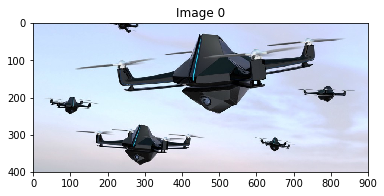

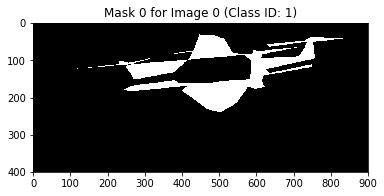

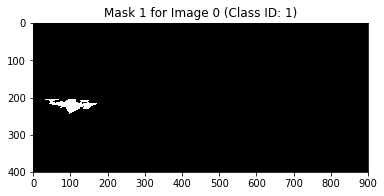

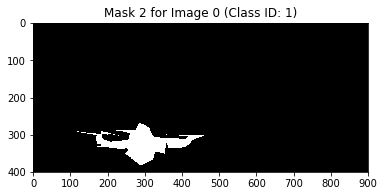

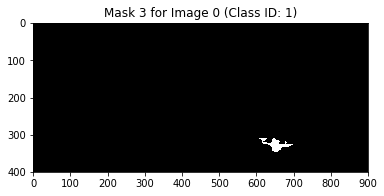

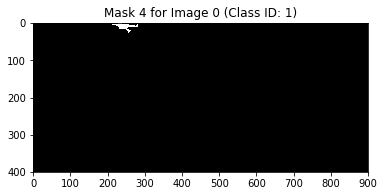

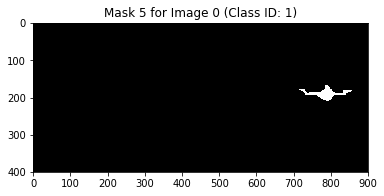

In [82]:
import matplotlib.pyplot as plt

# Visualize an image and its mask
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)

# Show the image
plt.imshow(image)
plt.title(f"Image {image_id}")
plt.show()

# Show the masks
for i in range(mask.shape[-1]):
    plt.imshow(mask[:, :, i], cmap='gray')
    plt.title(f"Mask {i} for Image {image_id} (Class ID: {class_ids[i]})")
    plt.show()


In [13]:
from mrcnn.config import Config

class DroneConfig(Config):
    """Configuration for training on the drone dataset."""
    NAME = "drone_detection"
    
    GPU_COUNT = 1  # No GPU
    IMAGES_PER_GPU = 1  # Use 1 image per batch to reduce memory usage
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + 1 class (drone)
    
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    
    # Skip detections with < 60% confidence
    DETECTION_MIN_CONFIDENCE = 0.6

config = DroneConfig()


In [13]:
# Import the model
from mrcnn.model import MaskRCNN

# Create a new Mask R-CNN model in training mode
model = MaskRCNN(mode="training", config=config, model_dir="./logs")

# Load pre-trained weights (exclude layers that don't match our classes)
#model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=[
#    "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [40]:
import os
# Prepare the training dataset (80% of the data)
train_dataset = DroneDataset()
train_dataset.load_drone(dataset_dir="dataset", subset="train")
train_dataset.prepare()

# Prepare the validation dataset (20% of the data)
val_dataset = DroneDataset()
val_dataset.load_drone(dataset_dir="dataset", subset="train")
val_dataset.prepare()


In [15]:
model.train(train_dataset, val_dataset, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')
model.keras_model.save_weights("model.h5")


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs\drone_detection20241027T0849\mask_rcnn_drone_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

KeyboardInterrupt: 

In [15]:
print("Model Configuration:")
config.display()


Model Configuration:

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 1

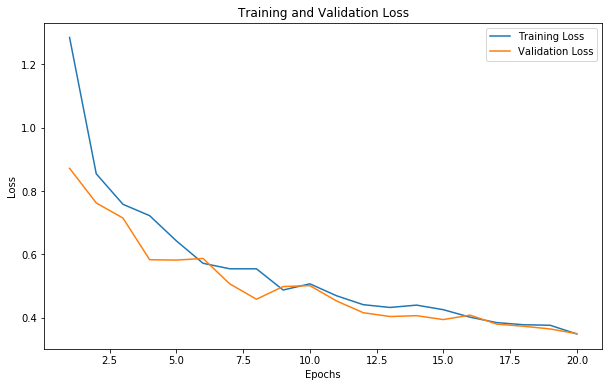

In [16]:
import matplotlib.pyplot as plt

# Données des époques
epochs = range(1, 21)

# Pertes d'entraînement et de validation
loss = [1.2853, 0.8544, 0.7581, 0.7221, 0.6426, 0.5717, 0.5543, 0.5542, 0.4872, 0.5068, 0.4691, 0.4409, 0.4321, 0.4395, 0.4250, 0.4014, 0.3842, 0.3775, 0.3758, 0.3483]
val_loss = [0.8718, 0.7624, 0.7146, 0.5829, 0.5818, 0.5869, 0.5067, 0.4581, 0.4982, 0.5011, 0.4527, 0.4155, 0.4035, 0.4061, 0.3938, 0.4079, 0.3794, 0.3727, 0.3642, 0.3492]

# Tracer les courbes de pertes
plt.figure(figsize=(10, 6))  
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [34]:
import tensorflow as tf
from mrcnn.model import MaskRCNN

# Initialiser une liste pour stocker les modèles
models = []

# Définir la structure de ton modèle
def get_model():
    model = MaskRCNN(mode="training", config=config, model_dir="logs")
    return model

# Charger les poids pour chaque époque
for epoch in range(1, 21):
    model_path = f'logs/drone_detection20241018T0748/mask_rcnn_drone_detection_{epoch:04d}.h5'
    model = get_model()
    model.load_weights(model_path, by_name=True)  # Passer le chemin du fichier directement ici
    models.append(model)


ValueError: slice index 0 of dimension 0 out of bounds. for 'ROI_21/strided_slice_6' (op: 'StridedSlice') with input shapes: [0,261888,4], [1], [1], [1] and with computed input tensors: input[1] = <0>, input[2] = <1>, input[3] = <1>.

In [36]:
import numpy as np
from tqdm import tqdm

def evaluer_drone_model(model, dataset, config):
    """
    Évalue le modèle Mask R-CNN sur le DroneDataset
    """
    print("Début de l'évaluation...")
    print(f"Nombre d'images dans le dataset: {len(dataset.image_ids)}")
    
    # Initialiser la matrice de confusion
    num_classes = len(config.CLASS_NAMES)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)
    
    # Pour chaque image dans le dataset
    for image_id in tqdm(dataset.image_ids):
        # Charger l'image
        image = dataset.load_image(image_id)
        if image is None:
            print(f"Erreur: Impossible de charger l'image {image_id}")
            continue
            
        # Charger les masques et classes de vérité terrain
        gt_masks, gt_class_ids = dataset.load_mask(image_id)
        if gt_masks is None or len(gt_class_ids) == 0:
            print(f"Attention: Pas de masques trouvés pour l'image {image_id}")
            continue
            
        print(f"\nImage {image_id}:")
        print(f"Classes vérité terrain: {gt_class_ids}")
        
        # Faire les prédictions
        # Assurez-vous que la taille du batch est 1 pour chaque image dans l'évaluation
        config.BATCH_SIZE = 1
        results = model.detect([image], verbose=0)[0]
        pred_class_ids = results['class_ids']
        pred_masks = results['masks']
        scores = results['scores']
        
        print(f"Classes prédites: {pred_class_ids}")
        print(f"Scores: {scores}")
        
        # Pour chaque prédiction, trouver la meilleure correspondance
        for i, pred_class in enumerate(pred_class_ids):
            best_iou = 0
            best_gt_idx = -1
            
            # Comparer avec chaque masque de vérité terrain
            for j, gt_class in enumerate(gt_class_ids):
                pred_mask = pred_masks[:, :, i]
                gt_mask = gt_masks[:, :, j]
                
                # Calculer IoU
                iou = calculate_iou(pred_mask, gt_mask)
                if iou > best_iou and iou >= 0.5:  # Seuil IoU de 0.5
                    best_iou = iou
                    best_gt_idx = j
            
            if best_gt_idx >= 0:
                # Ajouter à la matrice de confusion
                gt_class = gt_class_ids[best_gt_idx] - 1  # -1 car les classes commencent à 1
                pred_class = pred_class - 1
                confusion_matrix[gt_class, pred_class] += 1
                print(f"Match trouvé: Classe GT {gt_class+1} -> Pred {pred_class+1} (IoU: {best_iou:.3f})")
    
    return confusion_matrix

def calculate_iou(mask1, mask2):
    """
    Calcule l'Intersection over Union entre deux masques
    """
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0
    return intersection / union

def afficher_metriques(confusion_matrix, class_names):
    """
    Affiche les métriques pour chaque classe
    """
    print("\nMétriques par classe:")
    print("-" * 50)
    
    for i, class_name in enumerate(class_names):
        if confusion_matrix[i].sum() + confusion_matrix[:, i].sum() == 0:
            continue
            
        # Calculer précision et rappel
        true_positives = confusion_matrix[i, i]
        false_positives = confusion_matrix[:, i].sum() - true_positives
        false_negatives = confusion_matrix[i, :].sum() - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClasse {class_name}:")
        print(f"Précision: {precision:.3f}")
        print(f"Rappel: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")


In [37]:
# 1. D'abord, importez les bibliothèques nécessaires
import numpy as np
from tqdm import tqdm

# 2. Évaluez votre modèle sur le dataset de validation
print("Évaluation du modèle sur le dataset de validation...")
confusion_mat = evaluer_drone_model(model, val_dataset, config)

# 3. Affichez la matrice de confusion
print("\nMatrice de confusion:")
print(confusion_mat)

# 4. Affichez les métriques détaillées
afficher_metriques(confusion_mat, config.CLASS_NAMES)

# 5. Visualisation avec seaborn (optionnel)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, 
            annot=True, 
            fmt='d',
            xticklabels=config.CLASS_NAMES,
            yticklabels=config.CLASS_NAMES)
plt.title('Matrice de Confusion - Drone Dataset')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.show()

Évaluation du modèle sur le dataset de validation...
Début de l'évaluation...
Nombre d'images dans le dataset: 245


  0%|                                                                                          | 0/245 [00:00<?, ?it/s]


Image 0:
Classes vérité terrain: [1 1 1 1 1 1]







  0%|                                                                                          | 0/245 [03:27<?, ?it/s]


InvalidArgumentError: Input to reshape is a tensor with 600 values, but the requested shape has 0
	 [[node mrcnn_detection/Reshape_1 (defined at c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'mrcnn_detection/Reshape_1':
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2053236bf96b>", line 20, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 2044, in build
    [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 820, in call
    [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 131, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 8115, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [20]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ['BG', 'drone']  # Background and drone

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)




Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 20


In [41]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def collect_predictions(model, dataset):
    y_true = []
    y_pred = []

    for image_id in tqdm(dataset.image_ids):
        image = dataset.load_image(image_id)
        gt_class_ids = dataset.load_mask(image_id)[1]  # Classes de vérité terrain

        results = model.detect([image], verbose=0)[0]
        pred_class_ids = results['class_ids']  # Classes prédites

        y_true.extend(gt_class_ids)
        y_pred.extend(pred_class_ids)

    return y_true, y_pred

# Utilisation de la fonction
y_true, y_pred = collect_predictions(model, val_dataset)

# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=range(len(config.CLASS_NAMES)))

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config.CLASS_NAMES, yticklabels=config.CLASS_NAMES)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.savefig('images/confusion_matrix.png')
plt.show()


  0%|                                                                                          | 0/245 [00:21<?, ?it/s]


InvalidArgumentError: Input to reshape is a tensor with 600 values, but the requested shape has 0
	 [[node mrcnn_detection/Reshape_1 (defined at c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'mrcnn_detection/Reshape_1':
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2053236bf96b>", line 20, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 2044, in build
    [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 820, in call
    [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 131, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 8115, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mrcnn.visualize import display_instances
from skimage.draw import polygon as draw_polygon

# Define the missing polygon_to_mask function
def polygon_to_mask(polygon, height, width):
    """Convert polygon points to binary mask."""
    poly_x = [p[0] for p in polygon]
    poly_y = [p[1] for p in polygon]
    rr, cc = draw_polygon(poly_y, poly_x, shape=(height, width))
    return rr, cc

def visualize_detections(model, dataset):
    # Loop through the images in the dataset
    for image_id in dataset.image_ids:
        # Load the image
        image = dataset.load_image(image_id)
        
        # Get the ground truth (optional, just to know if it has a drone or not)
        gt_mask, gt_class_id = dataset.load_mask(image_id)
        true_label = "Drone" if len(gt_class_id) > 0 else "No Drone"
        
        # Predict using the model
        if image.shape[0] != 1024 or image.shape[1] != 1024:
            print(f"Resizing image {image_id} for detection")
            image = cv2.resize(image, (1024, 1024))
        
        result = model.detect([image], verbose=0)[0]
        pred_class_ids = result['class_ids']
        pred_scores = result['scores']
        pred_masks = result['masks']
        pred_bboxes = result['rois']
        
        # Determine if a drone is detected
        predicted_label = "Drone" if len(pred_class_ids) > 0 else "No Drone"
        
        # Print out the detection result
        print(f"Image {image_id}: True Label: {true_label}, Predicted Label: {predicted_label}")
        
        # If a drone is detected, display the image with segmentation and bounding box
        if predicted_label == "Drone":
            print(f"Drone detected with score: {pred_scores[0]:.2f}")
            # Visualize the image with the predicted mask, bounding box, and class name
            display_instances(image, pred_bboxes, pred_masks, pred_class_ids,
                              dataset.class_names, pred_scores)
            plt.show()

# Test the function on the validation dataset
visualize_detections(model, val_dataset)

    


Resizing image 0 for detection


InvalidArgumentError: Input to reshape is a tensor with 600 values, but the requested shape has 0
	 [[node mrcnn_detection/Reshape_1 (defined at c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'mrcnn_detection/Reshape_1':
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelapp.py", line 619, in start
    self.io_loop.start()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\base_events.py", line 1434, in _run_once
    handle._run()
  File "C:\Users\GHO\AppData\Local\Programs\Python\Python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 377, in dispatch_queue
    yield self.process_one()
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\contextvars\__init__.py", line 38, in run
    return callable(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2867, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 2895, in _run_cell
    return runner(coro)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3072, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3263, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "c:\users\gho\maskrcnn_env\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-2053236bf96b>", line 20, in <module>
    model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 1837, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 2044, in build
    [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\GHO\Mask_RCNN\mrcnn\model.py", line 820, in call
    [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 131, in reshape
    result = gen_array_ops.reshape(tensor, shape, name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 8115, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "c:\users\gho\maskrcnn_env\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()


In [39]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Ensure you use the correct GPU count
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model = _dir, 'mask_rcnn_drone_detection_0020.h5')


# Assuming you have DroneDataset class defined as before

# Define the paths to your dataset directories
dataset_dir = 'dataset'

# Initialize the training dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir, 'train')
dataset_train.prepare()

# Initialize the validation dataset
dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir, 'val')
dataset_val.prepare()


# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir="mask_rcnn_drone_detection_0020.h5")
print("Loading model weights...")
model.load_weights(model_path, by_name=True)
print("Model weights loaded.")


# Fine-tune the model with a lower learning rate
print("Starting fine-tuning...")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10,
            layers='all')
print("Fine-tuning finished.")

# Save the fine-tuned model weights
print("Saving fine-tuned weights...")
model.keras_model.save_weights("fine_tuned_model.h5")
print("Weights saved.")



SyntaxError: positional argument follows keyword argument (<ipython-input-39-890ad0820569>, line 16)

Re-starting from epoch 19
Object 1:
  Class: drone
  Bounding box: [   0    0    1 1024]
  Confidence score: 1.0


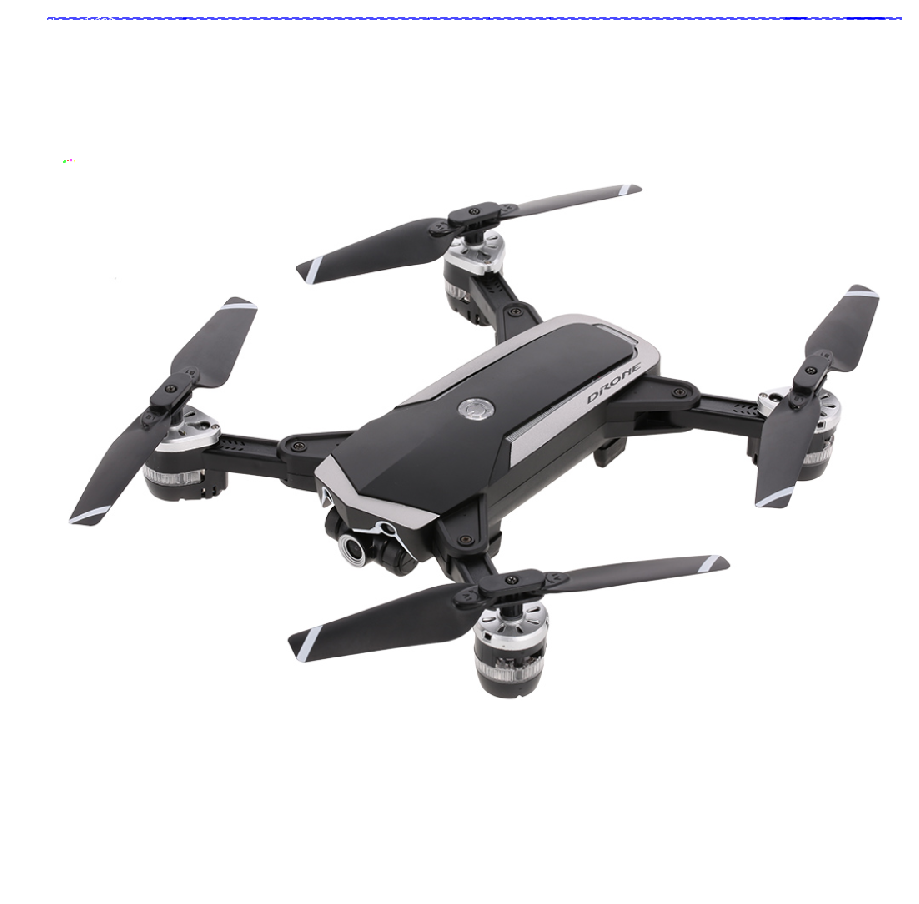

In [37]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import numpy as np
import random

# Class names
CLASS_NAMES = ['BG', 'drone']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"

    # Set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes = number of classes + 1 (+1 for the background).
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
model = mrcnn.model.MaskRCNN(mode="inference",
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="logs\drone_detection20241018T0748\mask_rcnn_drone_detection_0019.h5", by_name=True)

# Directory for validation images
validation_dir = "dataset/validation"
image_files = [f for f in os.listdir(validation_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Choose a random image file from the list
random_image_file = random.choice(image_files)

# Load the input image, convert it from BGR to RGB channel
image = cv2.imread(os.path.join(validation_dir, random_image_file))

# Resize the image while maintaining aspect ratio
height, width = image.shape[:2]
scale = 1024 / max(height, width)
resized_image = cv2.resize(image, (int(width * scale), int(height * scale)))

# Pad the image to 1024x1024 if needed
padded_image = np.zeros((1024, 1024, 3), dtype=np.uint8)
padded_image[:resized_image.shape[0], :resized_image.shape[1]] = resized_image

# Check if the image was loaded properly
if padded_image is None:
    print("Error: Unable to load image. Check the file path.")
else:
    padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([padded_image])[0]

CONFIDENCE_THRESHOLD = 0.8  # Adjusted threshold
MIN_BOX_AREA = 100  # Minimum box area

# Filter indices of detections with scores higher than the threshold
high_confidence_indices = [i for i, score in enumerate(r['scores']) if score > CONFIDENCE_THRESHOLD]

# Loop through detections and filter based on confidence and bounding box size
for i in range(len(r['scores'])):
    y1, x1, y2, x2 = r['rois'][i]
    box_height = y2 - y1
    box_width = x2 - x1
    box_area = box_height * box_width
    
    if r['scores'][i] > CONFIDENCE_THRESHOLD and box_area > MIN_BOX_AREA:
        print(f"Object {i + 1}:")
        print(f"  Class: {CLASS_NAMES[r['class_ids'][i]]}")
        print(f"  Bounding box: {r['rois'][i]}")  # y1, x1, y2, x2
        print(f"  Confidence score: {r['scores'][i]}")
        # Break after the first detected drone
        break
    else:
        print(f"Filtered out Object {i + 1} with tiny bounding box or low confidence.")

# Visualize only the high-confidence detections
if len(high_confidence_indices) > 0:
    mrcnn.visualize.display_instances(image=padded_image,  # Use padded_image for visualization
                                      boxes=r['rois'][high_confidence_indices],
                                      masks=r['masks'][:, :, high_confidence_indices],
                                      class_ids=r['class_ids'][high_confidence_indices],
                                      class_names=CLASS_NAMES,
                                      scores=r['scores'][high_confidence_indices])
else:
    print("No high-confidence detections found.")


In [ ]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Utiliser le GPU pour l'entraînement
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.9
    CLASS_NAMES = ['BG', 'drone']  # Background and drone
    STEPS_PER_EPOCH = 100

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)

# Load the dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir="dataset", subset="train")
dataset_train.prepare()

dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir="dataset", subset="val")
dataset_val.prepare()

total_epochs = 30
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=total_epochs,
            layers='heads')

In [90]:
from mrcnn import model as modellib
from mrcnn.config import Config
import os

# Define configuration
class DroneDetectionConfig(Config):
    NAME = "drone_detection"
    GPU_COUNT = 1  # Utiliser le GPU pour l'entraînement
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # Background + drone
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_NMS_THRESHOLD = 0.4
    CLASS_NAMES = ['BG', 'drone']  # Background and drone
    STEPS_PER_EPOCH = 150
    VALIDATION_STEPS = 25
        # Ajuster les ancres pour mieux détecter
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    RPN_ANCHOR_RATIOS = [0.5, 1, 2]
    
    # Augmenter le nombre de propositions
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    TRAIN_ROIS_PER_IMAGE = 200

# Load the model
config = DroneDetectionConfig()
model_dir = 'logs/drone_detection20241018T0748'
model_path = os.path.join(model_dir, 'mask_rcnn_drone_detection_0020.h5')

# Create the model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)
model.load_weights(model_path, by_name=True)

# Load the dataset
dataset_train = DroneDataset()
dataset_train.load_drone(dataset_dir="dataset", subset="train")
dataset_train.prepare()

dataset_val = DroneDataset()
dataset_val.load_drone(dataset_dir="dataset", subset="val")
dataset_val.prepare()

total_epochs = 30
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 100,
            epochs=total_epochs,
            layers='heads')

Re-starting from epoch 20

Starting at epoch 20. LR=1e-05

Checkpoint Path: logs/drone_detection20241018T0748\drone_detection20241018T0748\mask_rcnn_drone_detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)